# EXPLORE SEDML

# phrasedml basics

In [30]:
import tellurium as te
te.setDefaultPlottingEngine('matplotlib')
import phrasedml

antimony_str = '''
model myModel
  S1 -> S2; k1*S1
  S1 = 10; S2 = 0
  k1 = 1
end
'''

phrasedml_str = '''
  model1 = model "myModel"
  sim1 = simulate uniform(0, 5, 100)
  task1 = run sim1 on model1
  plot "Figure 2" time vs S1, S2
'''
#plot "Figure 1" time vs S1, S2

# create the sedml xml string from the phrasedml
sbml_str = te.antimonyToSBML(antimony_str)
phrasedml.setReferencedSBML("myModel", sbml_str)

sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    print(phrasedml.getLastPhrasedError())
print(sedml_str)

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="myModel"/>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="sim1" initialTime="0" outputStartTime="0" outputEndTime="5" numberOfSteps="100">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task1" modelReference="model1" simulationReference="sim1"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="plot_0_0_0" name="time">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> time </ci>
      </math>
      <listOfVariables>
        <variable id="time" symbol="urn:sedml:symbol:time" taskReference="task1" model

In [31]:
print(phrasedml_str)


  model1 = model "myModel"
  sim1 = simulate uniform(0, 5, 100)
  task1 = run sim1 on model1
  plot "Figure 2" time vs S1, S2



SBML written to temporary file
SED-ML written to temporary file
Read SED-ML file, number of errors: 0


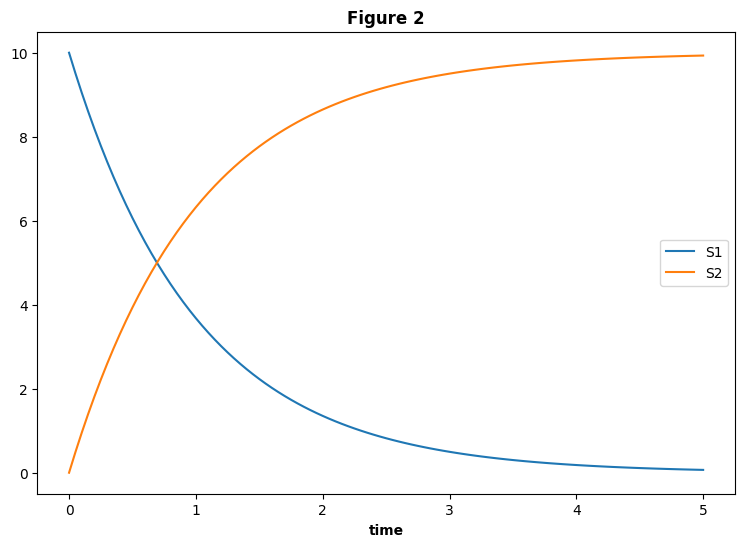

In [32]:
import tempfile, os, shutil

workingDir = tempfile.mkdtemp(suffix="_sedml")

sbml_file = os.path.join(workingDir, 'myModel')
sedml_file = os.path.join(workingDir, 'sed_main.xml')

with open(sbml_file, 'wb') as f:
    f.write(sbml_str.encode('utf-8'))
    f.flush()
    print('SBML written to temporary file')

with open(sedml_file, 'wb') as f:
    f.write(sedml_str.encode('utf-8'))
    f.flush()
    print('SED-ML written to temporary file')

# For technical reasons, any software which uses libSEDML
# must provide a custom build - Tellurium uses tesedml
try:
    import libsedml
except ImportError:
    import tesedml as libsedml
sedml_doc = libsedml.readSedML(sedml_file)
n_errors = sedml_doc.getErrorLog().getNumFailsWithSeverity(libsedml.LIBSEDML_SEV_ERROR)
print('Read SED-ML file, number of errors: {}'.format(n_errors))
if n_errors > 0:
    print(sedml_doc.getErrorLog().toString())

# execute SED-ML using Tellurium
te.executeSEDML(sedml_str, workingDir=workingDir)

# clean up
#shutil.rmtree(workingDir)

# Tasks for SimpleSEDML

1. Run a simulation with changed parameter values
2. Parameter scan
3. Compare the output from two different models
4. Compare simulation results with data

# Using Phrasedml generated from Claude

In [33]:
!ls /Users/jlheller/home/Technical/repos/SBMLModel/data/*206*

/Users/jlheller/home/Technical/repos/SBMLModel/data/BIOMD0000000206.xml


In [34]:
# Step 1: Reference the model
phrasedml.setWorkingDirectory("/Users/jlheller/home/Technical/repos/SBMLModel/data")
phrasedml_str = """
model1 = model "BIOMD0000000206.xml"
sim1 = simulate uniform(0, 10, 100)  # 0 to 10 seconds with 100 time points
task1 = run sim1 on model1
plot "BioModel 206 Simulation" time vs s1, s5
"""

In [35]:
phrasedml_str = phrasedml.convertString(phrasedml_str)
if len(phrasedml.getLastError()) > 0:
    print(phrasedml.getLastError())

In [37]:
dir(phrasedml.phrasedml)

['POINTER',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__libdir',
 '__loader__',
 '__name__',
 '__oldir',
 '__osname',
 '__package__',
 '__phrasedLib',
 '__sharedLib',
 '__spec__',
 '__thisfile',
 '__version__',
 'addDotXMLToModelSources',
 'c_bool',
 'c_char_p',
 'c_double',
 'c_int',
 'c_long',
 'c_ulong',
 'cdll',
 'clearReferencedSBML',
 'convertFile',
 'convertString',
 'freeAllPhrased',
 'getLastError',
 'getLastErrorLine',
 'getLastPhraSEDML',
 'getLastSEDML',
 'getPhrasedWarnings',
 'inspect',
 'os',
 'platform',
 'setReferencedSBML',
 'setWorkingDirectory',
 'setWriteSEDMLTimestamp']